In [1]:
!pip install pandas yfinance matplotlib scikit-learn numpy keras tensorflow 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import yfinance as yf

In [4]:
df = yf.download('AAPL', start="2015-01-01", end="2025-08-21")

/tmp/ipykernel_15607/4002006293.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start="2015-01-01", end="2025-08-21")
[*********************100%***********************]  1 of 1 completed


In [5]:
df.to_csv('AAPL_raw_data2.csv')

In [6]:
df = pd.read_csv('AAPL_raw_data2.csv', header=0, skiprows=[1, 2])

In [7]:
df.rename(columns={'Price': 'Date'}, inplace=True)

In [8]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [9]:
df['Change_Over_Time'] = df['Close'].diff()

In [10]:
df['Change_Over_Time'].fillna(0, inplace=True)

/tmp/ipykernel_15607/2688746579.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Change_Over_Time'].fillna(0, inplace=True)


In [11]:
df['typical_price'] = (df['High'] + df['Low'] + df['Close']) / 3
df['tp_volume'] = df['typical_price'] * df['Volume']
df['VWAP'] = df['tp_volume'].groupby(df.index.date).cumsum() / df['Volume'].groupby(df.index.date).cumsum()

In [12]:
df = df.drop(columns=['typical_price', 'tp_volume'])

In [13]:
df.head()

,Close,High,Low,Open,Volume,Change_Over_Time,VWAP
Date,,,,,,,
2015-01-02,24.261051,24.729274,23.821675,24.718178,212818400,0.000000,24.270667
2015-01-05,23.577568,24.110144,23.391167,24.030258,257142000,-0.683483,23.692960
2015-01-06,23.579800,23.839430,23.218091,23.641933,263188400,0.002232,23.545773
2015-01-07,23.910437,24.010294,23.677434,23.788387,160423600,0.330637,23.866055
2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000,0.918692,24.612399


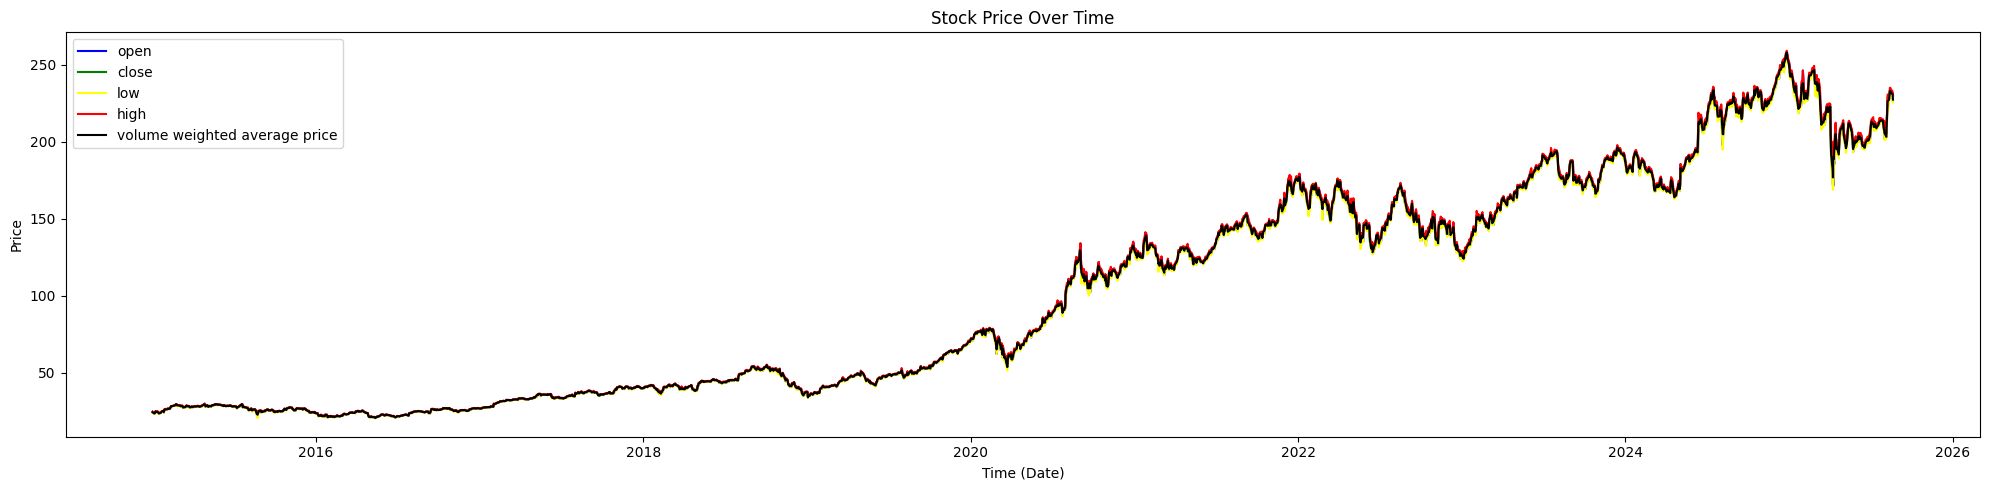

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.subplot(1, 1, 1)

plt.plot(df.index, df['Open'], color='blue', label='open')
plt.plot(df.index, df['Close'], color='green', label='close')
plt.plot(df.index, df['Low'], color='yellow', label='low')
plt.plot(df.index, df['High'], color='red', label='high')
plt.plot(df.index, df['VWAP'], color='black', label='volume weighted average price')

plt.title('Stock Price Over Time')
plt.xlabel('Time (Date)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.preprocessing import MinMaxScaler

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']
data = df[features].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [37]:
look_back_window = 60
forecast_horizon = 400

def create_multi_step_dataset(dataset, look_back_window, forecast_horizon):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back_window - forecast_horizon):
        a = dataset[i:(i + look_back_window), :]
        dataX.append(a)
        b = dataset[i + look_back_window:i + look_back_window + forecast_horizon, 3] # Predict 'Close' price
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [38]:
import numpy as np

train_size = int(len(scaled_data) * 0.70)
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

trainX, trainY = create_multi_step_dataset(train_data, look_back_window, forecast_horizon)
testX, testY = create_multi_step_dataset(test_data, look_back_window, forecast_horizon)


In [39]:
print(f"Dataset created with look_back_window={look_back_window} and forecast_horizon={forecast_horizon}")
print(f"Training data shape (X, Y): {trainX.shape}, {trainY.shape}")
print(f"Testing data shape (X, Y): {testX.shape}, {testY.shape}")

Dataset created with look_back_window=60 and forecast_horizon=400
Training data shape (X, Y): (1411, 60, 6), (1411, 400)
Testing data shape (X, Y): (343, 60, 6), (343, 400)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(
    units=50,
    return_sequences=True,
    input_shape=(look_back_window, len(features))
))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=forecast_horizon, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

/home/gitpod/.pyenv/versions/3.12.11/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(testX, testY), verbose=1)

Epoch 1/50


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0201 - val_loss: 0.0423
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0046 - val_loss: 0.0405
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0041 - val_loss: 0.0409
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0039 - val_loss: 0.0384
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0038 - val_loss: 0.0493
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0037 - val_loss: 0.0411
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0035 - val_loss: 0.0555
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0033 - val_loss: 0.0487
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0033 - val_loss: 0.0352
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0033 - val_loss: 0.0402
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0031 - val_loss: 0.0434
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0031 - val_

In [42]:
last_60_days_scaled = scaled_data[len(scaled_data) - look_back_window:]
last_60_days_scaled = last_60_days_scaled.reshape(1, look_back_window, len(features))
future_predictions_scaled = model.predict(last_60_days_scaled, verbose=0)
future_predictions_scaled = future_predictions_scaled.reshape(-1, 1)

In [43]:
temp_predictions = np.zeros((forecast_horizon, len(features)))
temp_predictions[:, 3] = future_predictions_scaled.flatten()
future_predictions = scaler.inverse_transform(temp_predictions)[:, 3]

In [44]:
last_actual_date = df.index[-1]
forecast_dates = pd.to_datetime(last_actual_date) + pd.to_timedelta(np.arange(1, forecast_horizon + 1), unit='d')
forecast_df = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Forecast'])

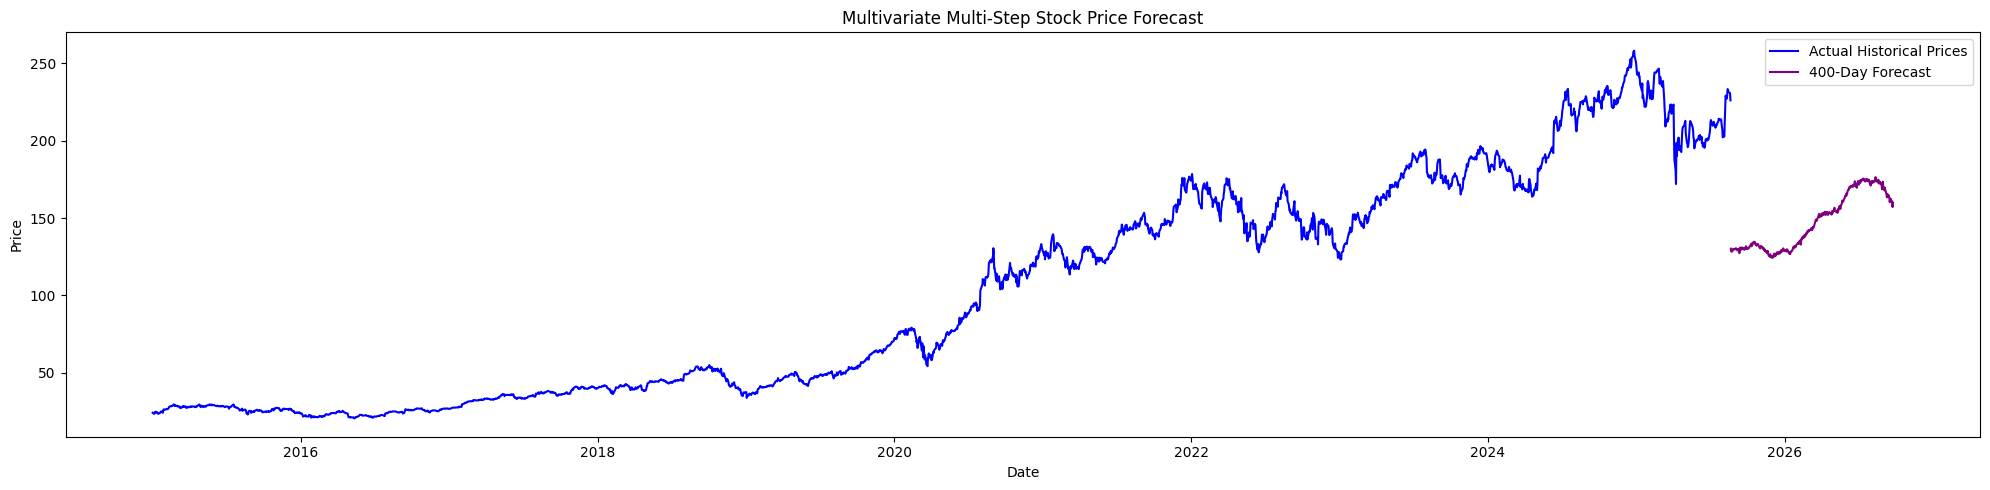

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['Close'], color='blue', label='Actual Historical Prices')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='purple', label=f'{forecast_horizon}-Day Forecast')
plt.title('Multivariate Multi-Step Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()